In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from striatum.storage import action
from striatum.storage import history
from striatum.storage import model
from striatum.bandit import ucb1
from striatum.bandit import linucb
from striatum.bandit import linthompsamp
from striatum.bandit import exp4p
from striatum.bandit import exp3
from striatum.bandit.bandit import BaseBandit
# from striatum.bandit.bandit import Action
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# /Users/01017387/Desktop/jupyter
def get_data():
    streaming_batch = pd.read_csv('streaming_batch.csv', sep='\t', names=['user_id'], engine='c')
    user_feature = pd.read_csv('user_feature.csv', sep='\t', header=0, index_col=0, engine='c')
#     actions_id = list(pd.read_csv('actions.csv', sep='\t', header=0, engine='c')['movie_id'])
    actions = list(pd.read_csv('actions.csv', sep='\t', header=0, engine='c')['movie_id'])
    reward_list = pd.read_csv('reward_list.csv', sep='\t', header=0, engine='c')
    action_context = pd.read_csv('action_context.csv', sep='\t', header=0, engine='c')

#     actions = []
#     for key in actions_id:
# #         action = Action(key)
#         action = BaseBandit(key)
#         actions.append(action)

    return streaming_batch, user_feature, actions, reward_list, action_context

#線形モデルの構築、モデルを返す
def train_expert(action_context):
    logreg = OneVsRestClassifier(LogisticRegression())
    mnb = OneVsRestClassifier(MultinomialNB(), )
    logreg.fit(action_context.iloc[:, 2:], action_context.iloc[:, 1])
    mnb.fit(action_context.iloc[:, 2:], action_context.iloc[:, 1])
    return [logreg, mnb]

#各時刻における、特徴量を使った線形モデルを構築、各時刻における各アクションの報酬を得られる確率を算出
def get_advice(context, actions_id, experts):
    advice = {}
    for time in context.keys():
        advice[time] = {}
        for i in range(len(experts)):
            prob = experts[i].predict_proba(context[time])[0]
            advice[time][i] = {}
            for j in range(len(prob)):
                advice[time][i][actions_id[j]] = prob[j]
    return advice

#actions : list of actions should be choosed from
# →list of movieID
#policy=方策、banditが従うアルゴリズム
def policy_generation(bandit, actions):
    historystorage = history.MemoryHistoryStorage()
    modelstorage = model.MemoryModelStorage()

    if bandit == 'Exp4P':
        #選択できるアクション、行動履歴、モデルを入れてる？
        #delta、pminの意味を探る必要ある
        policy = exp4p.Exp4P(actions, historystorage, modelstorage, delta=0.5, p_min=None)

    elif bandit == 'LinUCB':
#         policy = linucb.LinUCB(actions, historystorage, modelstorage, 0.3, 20)
        policy = linucb.LinUCB(historystorage, modelstorage, actions,  0.3, 20)

    elif bandit == 'LinThompSamp':
#         policy = linthompsamp.LinThompSamp(historystorage, modelstorage, actions, d=20, delta=0.61, r=0.01, epsilon=0.71)
        policy = linthompsamp.LinThompSamp(historystorage, modelstorage, actions, delta=0.61, R=0.01, epsilon=0.71)

    elif bandit == 'UCB1':
        policy = ucb1.UCB1(historystorage, modelstorage, actions)

    elif bandit == 'Exp3':
        policy = exp3.Exp3(historystorage, modelstorage, actions, gamma=0.2)

    elif bandit == 'random':
        policy = 0

    return policy

#選択評価
def policy_evaluation(policy, bandit, streaming_batch, user_feature, reward_list, actions, action_context=None):
    times = len(streaming_batch)
    seq_error = np.zeros(shape=(times, 1))
#     actions_id = [actions[i].action_id for i in range(len(actions))]
    actions_id = [actions[i] for i in range(len(actions))]
    if bandit in ['LinUCB', 'LinThompSamp', 'UCB1', 'Exp3']:
        for t in range(times):
            feature = np.array(user_feature[user_feature.index == streaming_batch.iloc[t, 0]])[0]
            full_context = {}
            for action_id in actions_id:
                full_context[action_id] = feature
            history_id, action = policy.get_action(full_context, 1)
            watched_list = reward_list[reward_list['user_id'] == streaming_batch.iloc[t, 0]]

            if action[0]['action'].action_id not in list(watched_list['movie_id']):
                policy.reward(history_id, {action[0]['action'].action_id: 0.0})
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0

            else:
                policy.reward(history_id, {action[0]['action'].action_id: 1.0})
                if t > 0:
                    seq_error[t] = seq_error[t - 1]

    elif bandit == 'Exp4P':
        for t in range(times):
            feature = user_feature[user_feature.index == streaming_batch.iloc[t, 0]]
            experts = train_expert(action_context)
            advice = {}
            for i in range(len(experts)):
                prob = experts[i].predict_proba(feature)[0]
                advice[i] = {}
                for j in range(len(prob)):
                    advice[i][actions_id[j]] = prob[j]
            history_id, action = policy.get_action(advice)
            watched_list = reward_list[reward_list['user_id'] == streaming_batch.iloc[t, 0]]

            if action[0]['action'].action_id not in list(watched_list['movie_id']):
                policy.reward(history_id, {action[0]['action'].action_id: 0.0})
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0

            else:
                policy.reward(history_id, {action[0]['action'].action_id: 1.0})
                if t > 0:
                    seq_error[t] = seq_error[t - 1]

    elif bandit == 'random':
        for t in range(times):
            action = actions_id[np.random.randint(0, len(actions)-1)]
            watched_list = reward_list[reward_list['user_id'] == streaming_batch.iloc[t, 0]]

            if action not in list(watched_list['movie_id']):
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0

            else:
                if t > 0:
                    seq_error[t] = seq_error[t - 1]

    return seq_error

#regretの計算
def regret_calculation(seq_error):
    t = len(seq_error)
    regret = [x / y for x, y in zip(seq_error, range(1, t + 1))]
    return regret



In [3]:
#1万件で試す
#データの生成
streaming_batch, user_feature, actions, reward_list, action_context = get_data()
streaming_batch_small = streaming_batch.iloc[0:10000]

In [4]:
# conduct regret analyses
experiment_bandit = ['LinUCB', 'LinThompSamp', 'Exp4P', 'UCB1', 'Exp3', 'random']
# experiment_bandit = 'Exp4P'
regret = {}
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
# col = 'b'
i = 0


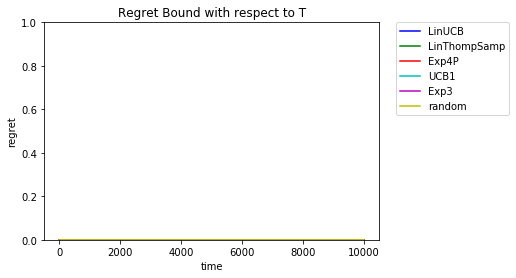

In [5]:
#コードにエラーはないけど、regretがうまく計算されていない模様
#     for bandit in experiment_bandit:
for bandit in experiment_bandit:
    policy = policy_generation(bandit, actions)
    seq_error = policy_evaluation(policy, experiment_bandit, streaming_batch_small, user_feature, reward_list, actions, action_context)
    regret[bandit] = regret_calculation(seq_error)
#     plt.plot(range(len(streaming_batch_small)), regret[bandit], c=col[i], ls='-', label=bandit)
    plt.plot(range(len(streaming_batch_small)), regret[bandit], c=col[i], ls='-', label=bandit)
    plt.xlabel('time')
    plt.ylabel('regret')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.title("Regret Bound with respect to T")
    i += 1
plt.show()

In [36]:
experiment_bandit = ['LinUCB', 'LinThompSamp', 'Exp4P', 'UCB1', 'Exp3']
# experiment_bandit = ['LinUCB', 'LinThompSamp', 'Exp4P', 'UCB1', 'Exp3', 'random']
# experiment_bandit = 'LinUCB'
# po = []
# c = 0
for bandit in experiment_bandit:
    policy = policy_generation(bandit, actions)
#     seq_error = policy_evaluation(policy, experiment_bandit, streaming_batch_small, user_feature, reward_list, actions, action_context)
#     print(policy)
#     c +=1

In [10]:
#6040人分の特徴量が入っている
user_feature
#user_id, movie_idごとにrewardのフラグが入っている（評価３をつけたもの以上）
reward_list
#top50の映画が入っている
len(actions)
#movie_id,ジャンル（特徴量）が映画ごとに入っている
# action_context
# →これらを各アルゴリズムの名前がついたオブジェクトに突っ込んで、seq_errorを出す

,movie_id,movie_name,tag0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17
0,1,Toy Story (1995),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,34,Babe (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,50,"Usual Suspects, The (1995)",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,110,Braveheart (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,260,Star Wars: Episode IV - A New Hope (1977),1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,296,Pulp Fiction (1994),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,318,"Shawshank Redemption, The (1994)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,356,Forrest Gump (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,457,"Fugitive, The (1993)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,480,Jurassic Park (1993),1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [54]:
# policy.model
times = len(streaming_batch)
seq_error = np.zeros(shape=(times, 1))
actions_id = [i for i in actions]

c = 0
for t in range(times):
    feature = np.array(user_feature[user_feature.index == streaming_batch.iloc[t, 0]])[0]
#     print(feature)
    full_context = {}
    for action_id in actions_id:
        full_context[action_id] = feature
    history_id, action = policy.get_action(full_context, 1)
    watched_list = reward_list[reward_list['user_id'] == streaming_batch.iloc[t, 0]]

    if action[0]['action'].action_id not in list(watched_list['movie_id']):
        policy.reward(history_id, {action[0]['action'].action_id: 0.0})
        if t == 0:
            seq_error[t] = 1.0
        else:
            seq_error[t] = seq_error[t - 1] + 1.0

    else:
        policy.reward(history_id, {action[0]['action'].action_id: 1.0})
        if t > 0:
            seq_error[t] = seq_error[t - 1]
    c +=1
    if c >=2:
        break



TypeError: count() takes exactly one argument (0 given)

In [55]:
# actions_id
self._action_storage?

Object `self._action_storage` not found.


In [3]:
#1万件で試す
def main():
    #データの生成
    streaming_batch, user_feature, actions, reward_list, action_context = get_data()
    streaming_batch_small = streaming_batch.iloc[0:10000]

    # conduct regret analyses
#     experiment_bandit = ['LinUCB', 'LinThompSamp', 'Exp4P', 'UCB1', 'Exp3', 'random']
    experiment_bandit = 'Exp4P'
    regret = {}
#     col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    col = 'b'
    i = 0
#     for bandit in experiment_bandit:
    policy = policy_generation(experiment_bandit, actions)
    seq_error = policy_evaluation(policy, experiment_bandit, streaming_batch_small, user_feature, reward_list,
                                  actions, action_context)
    regret[experiment_bandit] = regret_calculation(seq_error)
    plt.plot(range(len(streaming_batch_small)), regret[experiment_bandit], c=col[i], ls='-', label=experiment_bandit)
    plt.xlabel('time')
    plt.ylabel('regret')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.title("Regret Bound with respect to T")
    i += 1
    plt.show()

In [4]:
# #全体バージョンはエラーが出るので一旦やめ
# def main():
#     streaming_batch, user_feature, actions, reward_list, action_context = get_data()
#     streaming_batch_small = streaming_batch.iloc[0:10000]

#     # conduct regret analyses
# #     experiment_bandit = ['LinUCB', 'LinThompSamp', 'Exp4P', 'UCB1', 'Exp3', 'random']
#     experiment_bandit = 'Exp4P'
#     regret = {}
# #     col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
#     col = 'b'
#     i = 0
#     for bandit in experiment_bandit:
#         policy = policy_generation(bandit, actions)
#         seq_error = policy_evaluation(policy, bandit, streaming_batch_small, user_feature, reward_list,
#                                       actions, action_context)
#         regret[bandit] = regret_calculation(seq_error)
#         plt.plot(range(len(streaming_batch_small)), regret[bandit], c=col[i], ls='-', label=bandit)
#         plt.xlabel('time')
#         plt.ylabel('regret')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         axes = plt.gca()
#         axes.set_ylim([0, 1])
#         plt.title("Regret Bound with respect to T")
#         i += 1
#     plt.show()

In [5]:
if __name__ == '__main__':
    main()

AttributeError: 'Exp4P' object has no attribute 'action_ids'

In [12]:
class exper():
    def print_val(self,a):
        print(a)

#クラスの引数に他のクラス
#defの中身にsuper()をつけた上で、メソッド呼び出し
class subtle(exper):
    def summa(self,b):
        super().print_val(b)
        c = 0
        for i in n:
            c +=i
        return c

In [13]:
n = list(range(4))
e = exper()
j = subtle()
j.summa(n)

[0, 1, 2, 3]


6

6

In [12]:
n

[0, 1, 2, 3]